In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from preprocessing import *

In [3]:
X = pd.read_csv('Data\X_train.csv')
y = pd.read_csv('Data\y_train.csv')
X_test = pd.read_csv('Data\X_test.csv')

X.head()
#y.head()

,id,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x822,x823,x824,x825,x826,x827,x828,x829,x830,x831
0,0.0,14168.823171,10514.380717,3316.149698,94230.695124,102.386606,92.677127,11108.748199,10866.505510,10837.622093,...,NaN,12352.094085,846.014651,105.132144,102.112809,2090.004260,2.691845,1234.374109,1000.784475,9285.751272
1,1.0,17757.037554,NaN,4101.016273,92959.527633,NaN,99.855168,10013.959449,10826.607494,10076.101597,...,NaN,16198.071494,776.084467,106.385590,103.472030,2474.051881,2.287976,NaN,1012.626705,11750.284764
2,2.0,14226.656663,11029.642499,NaN,124055.600561,100.542483,92.860892,NaN,10492.342868,NaN,...,10329.704431,13976.063780,737.040332,103.671234,109.458246,2656.083281,2.843706,888.353607,1048.810385,9553.922728
3,3.0,8766.012436,7384.202998,2147.308418,100157.719990,104.855061,101.929026,10050.049932,10499.521099,10525.030989,...,10008.251395,6212.127347,329.044233,105.084488,104.858546,1097.785204,2.732257,927.752967,1048.357330,NaN
4,4.0,13801.016418,13269.493652,3408.316953,92048.527786,103.759758,95.789235,9667.353978,10750.783106,10618.800750,...,10095.782015,13772.061493,NaN,NaN,100.369834,2693.053231,2.702908,1471.354073,1071.284484,9423.533063


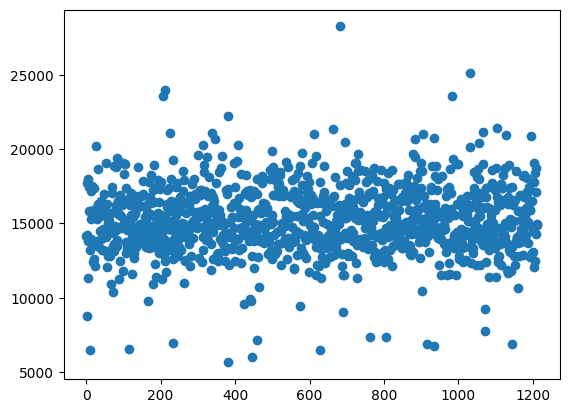

In [26]:
plt.scatter(X['id'],X['x0'])

In [27]:
print(len(X['id']))

1212


In [4]:
X.drop('id', axis=1, inplace=True)
y.drop('id', axis=1, inplace=True)

X = X.to_numpy()
y = y.to_numpy().ravel()

In [5]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import LassoCV,Ridge
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

In [75]:
def find_best_model(X, y):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    
    # Define the hyperparameter grid
    n_estimators_values = [100, 200]
    max_depth_values = [None, 10, 20]
    min_samples_split_values = [2, 5]
    n_neighbors_values = [2, 3, 4]
    n_clusters_values = [3, 4]
    contamination_values = [0.01, 0.05, 0.1]
    
    # Track the best score and corresponding hyperparameters
    best_score = -np.inf
    best_params = {}
    
    accuracies = []
    
    i = 0
    for contamination in contamination_values:
        for n_estimators in n_estimators_values:
            for max_depth in max_depth_values:
                for min_samples_split in min_samples_split_values:
                    for n_neighbors in n_neighbors_values:
                        for n_clusters in n_clusters_values:
                            accuracies = []
                            
                            # Perform cross-validation for each combination of hyperparameters
                            for train_index, val_index in kf.split(X):
                                X_train, X_val = X[train_index], X[val_index]
                                y_train, y_val = y[train_index], y[val_index]
                                
                                
                
                                # Step 1: Imputation (use n_neighbors as hyperparameter for KNNImputer)
                                X_train_imputed, imputer = replace_NaN(X_train, n_neighbors)
                                
                
                                X_val_imputed = imputer.transform(X_val)
                
                                # Step 3: Normalize features
                                X_train_normalized, scaler = normalize_features(X_train_imputed)
                                X_val_normalized = scaler.transform(X_val_imputed)
                
                                # Step 4: Outlier detection (use n_clusters as hyperparameter)
                                anomalies1 = detect_outliers_PCA_GMM(X_train_normalized, n_clusters=n_clusters)
                                #anomalies2 = detect_outliers_Autoencoders(X_train_normalized)
                                anomalies3 = detect_outliers_IsolationForest(X_train_normalized, contamination=contamination)
                                
                                anomalies = anomalies1 | anomalies3
                                
                                X_train_final = X_train_normalized[~anomalies]
                                y_train_final = y_train[~anomalies]
                
                                selector = SelectKBest(f_regression, k=200)
                                
                                X_train_final = selector.fit_transform(X_train_final, y_train_final)
                                X_val_normalized = selector.transform(X_val_normalized)
                                # Step 5: Train the model
                                model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, n_jobs=-1)
                                model.fit(X_train_final, y_train_final)
                
                                # Step 6: Validate the model
                                y_pred = model.predict(X_val_normalized)
                
                                # Step 7: Calculate accuracy (using R² score)
                                accuracies.append(r2_score(y_val, y_pred))
                
                            # Compute the mean R² score for this combination of hyperparameters
                            mean_accuracy = np.mean(accuracies)
                            
                            current_params = {
                                'n_estimators': n_estimators,
                                'max_depth': max_depth,
                                'min_samples_split': min_samples_split,
                                'n_neighbors': n_neighbors,
                                'n_clusters': n_clusters,
                                'contamination': contamination
                            }
                            
                            print(f"Iteration {i}: {current_params} -> {mean_accuracy}")
                            
                            i += 1
                            # If the current mean_accuracy is better than the best score, update the best parameters
                            if mean_accuracy > best_score:
                                best_score = mean_accuracy
                                best_params = current_params
    
    return best_params, best_score

    

In [76]:
best_params, best_score = find_best_model(X, y)

print("Best_params: ", best_params," Best_score: ", best_score)

Iteration 0: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'n_neighbors': 2, 'n_clusters': 3, 'contamination': 0.01} -> 0.48296825864358883
Iteration 1: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'n_neighbors': 2, 'n_clusters': 4, 'contamination': 0.01} -> 0.48279755994331053
Iteration 2: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'n_neighbors': 3, 'n_clusters': 3, 'contamination': 0.01} -> 0.48582321179888605
Iteration 3: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'n_neighbors': 3, 'n_clusters': 4, 'contamination': 0.01} -> 0.4802356162529472
Iteration 4: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'n_neighbors': 4, 'n_clusters': 3, 'contamination': 0.01} -> 0.4703647782610165
Iteration 5: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'n_neighbors': 4, 'n_clusters': 4, 'contamination': 0.01} -> 0.4793200805791237
Iteration 6: {'n_estimators': 100, 'max_depth': N

KeyboardInterrupt: 

In [34]:
# Random Forest Best_params:  {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 5, 'n_neighbors': 3, 'n_clusters': 3, 'contamination': 0.01}  Best_score:  0.45824414916035056

best_params = {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 5, 'n_neighbors': 3, 'n_clusters': 3, 'contamination': 0.01}

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Apply imputation with the best number of neighbors
X_train_imputed, imputer = replace_NaN(X_train, best_params['n_neighbors'])
X_val_imputed = imputer.transform(X_val)

# Normalize features
X_train_normalized, scaler = normalize_features(X_train_imputed)
X_val_normalized = scaler.transform(X_val_imputed)

# Detect outliers
anomalies1 = detect_outliers_PCA_GMM(X_train_normalized, n_clusters=best_params['n_clusters'])
anomalies2 = detect_outliers_Autoencoders(X_train_normalized)
anomalies3 = detect_outliers_IsolationForest(X_train_normalized, contamination=best_params['contamination'])
anomalies = anomalies1 & anomalies2 & anomalies3



# Filter outliers from the training data
X_train_final = X_train_normalized[~anomalies]
y_train_final = y_train[~anomalies]


# Feature selection
selector = SelectKBest(f_regression, k=100)
X_train_final = selector.fit_transform(X_train_final, y_train_final)
X_val_final = selector.transform(X_val_normalized)

# Alternative feature selection
"""lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train_final, y_train_final)
lasso_coef = lasso.coef_

selected_features = np.where(lasso_coef != 0)[0]

X_train_final = X_train_final[:, selected_features]
X_val_final = X_val_normalized[:, selected_features]"""

# Train and evaluate the final RandomForestRegressor model
model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    random_state=42
)
model.fit(X_train_final, y_train_final)

# Evaluate performance
train_r2 = r2_score(y_train_final, model.predict(X_train_final))
val_r2 = r2_score(y_val, model.predict(X_val_final))

print("Training R²:", train_r2)
print("Validation R²:", val_r2)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\smyan\anaconda3\envs\AML_projects\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.08568490379548, tolerance: 8.324687041284406
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\smyan\anaconda3\envs\AML_projects\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.877630300965393, tolerance: 8.324687041284406
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\smyan\anaconda3\envs\AML_projects\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.52034742050091, tolerance: 8.324687041284406
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\smyan\anaconda3\envs\AML_proje

Training R²: 0.9152032922057874
Validation R²: 0.41061653411154386


In [16]:
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score

In [20]:
def tune_gradient_boosting(X, y, param_grid, n_neighbors, n_clusters, contamination):
    """
    Tune the GradientBoostingRegressor model using cross-validation with preprocessing in each fold.
    
    Parameters:
    - X: Features (numpy array or pandas DataFrame)
    - y: Target values (numpy array or pandas Series)
    - param_grid: Dictionary with hyperparameters for GradientBoostingRegressor to tune
    - n_neighbors: Number of neighbors for KNNImputer
    - n_clusters: Number of clusters for PCA-GMM outlier detection
    - contamination: Contamination rate for IsolationForest outlier detection
    
    Returns:
    - best_params: Best parameters for the GradientBoostingRegressor based on cross-validation
    - best_score: Best mean R² score achieved
    """
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    best_score = -np.inf
    best_params = {}

    for n_estimators in param_grid['n_estimators']:
        for learning_rate in param_grid['learning_rate']:
            for max_depth in param_grid['max_depth']:
                
                # Track accuracies for current hyperparameters
                accuracies = []
                
                # Cross-validation loop with data preprocessing
                for train_index, val_index in kf.split(X):
                    X_train, X_val = X[train_index], X[val_index]
                    y_train, y_val = y[train_index], y[val_index]
                    
                    # Step 1: Imputation
                    X_train_imputed, imputer = replace_NaN(X_train, n_neighbors)
                    X_val_imputed = imputer.transform(X_val)
    
                    # Step 2: Normalize features
                    X_train_normalized, scaler = normalize_features(X_train_imputed)
                    X_val_normalized = scaler.transform(X_val_imputed)
    
                    # Step 3: Outlier detection
                    anomalies1 = detect_outliers_PCA_GMM(X_train_normalized, n_clusters=n_clusters)
                    anomalies2 = detect_outliers_Autoencoders(X_train_normalized)
                    anomalies3 = detect_outliers_IsolationForest(X_train_normalized, contamination=contamination)
                    
                    anomalies = anomalies1 | anomalies2 | anomalies3
                    X_train_final = X_train_normalized[~anomalies]
                    y_train_final = y_train[~anomalies]
    
                    # Step 4: Feature selection
                    selector = SelectKBest(f_regression, k=500)
                    X_train_final = selector.fit_transform(X_train_final, y_train_final)
                    X_val_final = selector.transform(X_val_normalized)
                    
                    # Step 5: Train GradientBoostingRegressor with current hyperparameters
                    gbr = GradientBoostingRegressor(
                        n_estimators=n_estimators,
                        learning_rate=learning_rate,
                        max_depth=max_depth,
                        random_state=42
                    )
                    gbr.fit(X_train_final, y_train_final)
                    
                    # Step 6: Validate the model
                    y_pred = gbr.predict(X_val_final)
                    accuracies.append(r2_score(y_val, y_pred))
                
                # Compute the mean R² score for this set of hyperparameters
                mean_accuracy = np.mean(accuracies)
                
                current_params = {
                    'n_estimators': n_estimators,
                    'learning_rate': learning_rate,
                    'max_depth': max_depth
                }
                
                print(f"Params: {current_params}, Mean R²: {mean_accuracy:.4f}")
                
                # Update best parameters if the current score is higher
                if mean_accuracy > best_score:
                    best_score = mean_accuracy
                    best_params = current_params

    print(f"\nBest Parameters: {best_params}, Best Mean R² Score: {best_score:.4f}")
    return best_params, best_score

In [21]:
param_grid = {
    'n_estimators': [100, 200],          # Number of boosting stages
    'learning_rate': [0.01, 0.1],        # Learning rate shrinks the contribution of each tree
    'max_depth': [3, 5]                  # Depth of individual trees
}

# Assuming X and y are your features and target values
best_params, best_score = tune_gradient_boosting(X, y, param_grid, n_neighbors=5, n_clusters=3, contamination=0.01)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Params: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 3}, Mean R²: 0.3265
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Params: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 5}, Mean R²: 0.3601
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━

In [50]:
def tune_extra_trees(X, y, param_grid, n_neighbors, n_clusters, contamination):
    """
    Tune the ExtraTreesRegressor model using cross-validation with preprocessing in each fold.
    
    Parameters:
    - X: Features (numpy array or pandas DataFrame)
    - y: Target values (numpy array or pandas Series)
    - param_grid: Dictionary with hyperparameters for ExtraTreesRegressor to tune
    - n_neighbors: Number of neighbors for KNNImputer
    - n_clusters: Number of clusters for PCA-GMM outlier detection
    - contamination: Contamination rate for IsolationForest outlier detection
    
    Returns:
    - best_params: Best parameters for the ExtraTreesRegressor based on cross-validation
    - best_score: Best mean R² score achieved
    """
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    best_score = -np.inf
    best_params = {}

    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for min_samples_split in param_grid['min_samples_split']:
                    
                    # Track accuracies for current hyperparameters
                    accuracies = []
                    
                    # Cross-validation loop with data preprocessing
                    for train_index, val_index in kf.split(X):
                        X_train, X_val = X[train_index], X[val_index]
                        y_train, y_val = y[train_index], y[val_index]
                        
                        # Step 1: Imputation
                        X_train_imputed, imputer = replace_NaN(X_train, n_neighbors)
                        X_val_imputed = imputer.transform(X_val)
        
                        # Step 2: Normalize features
                        X_train_normalized, scaler = normalize_features(X_train_imputed)
                        X_val_normalized = scaler.transform(X_val_imputed)
        
                        # Step 3: Outlier detection
                        anomalies1 = detect_outliers_PCA_GMM(X_train_normalized, n_clusters=n_clusters)
                        anomalies2 = detect_outliers_Autoencoders(X_train_normalized)
                        anomalies3 = detect_outliers_IsolationForest(X_train_normalized, contamination=contamination)
                        
                        anomalies = anomalies1 & anomalies2 & anomalies3
                        X_train_final = X_train_normalized[~anomalies]
                        y_train_final = y_train[~anomalies]
        
                        # Step 4: Feature selection
                        selector = SelectKBest(f_regression, k=500)
                        X_train_final = selector.fit_transform(X_train_final, y_train_final)
                        X_val_final = selector.transform(X_val_normalized)
                        
                        # Step 5: Train ExtraTreesRegressor with current hyperparameters
                        etr = ExtraTreesRegressor(
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_split=min_samples_split,
                            random_state=42
                        )
                        etr.fit(X_train_final, y_train_final)
                        
                        # Step 6: Validate the model
                        y_pred = etr.predict(X_val_final)
                        accuracies.append(r2_score(y_val, y_pred))
                    
                    # Compute the mean R² score for this set of hyperparameters
                    mean_accuracy = np.mean(accuracies)
                    
                    current_params = {
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                    }
                    
                    print(f"Params: {current_params}, Mean R²: {mean_accuracy:.4f}")
                    
                    # Update best parameters if the current score is higher
                    if mean_accuracy > best_score:
                        best_score = mean_accuracy
                        best_params = current_params

    print(f"\nBest Parameters: {best_params}, Best Mean R² Score: {best_score:.4f}")
    return best_params, best_score

In [51]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}

best_params, best_score = tune_extra_trees(X, y, param_grid, n_neighbors=5, n_clusters=3, contamination=0.01)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Params: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2}, Mean R²: 0.4602
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Params: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 5}, Mean R²: 0.4631
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
3

In [71]:
# Best Parameters Gradient Roosting Regressor : {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 5}, Best Mean R² Score: 0.4594
# Best Parameters Extra Trees Regressor: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 2}, Best Mean R² Score: 0.4710
# Combined Models


gboost = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
random_forest = RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=5, random_state=42)
xtra_trees = ExtraTreesRegressor(n_estimators=200, max_depth=20, min_samples_split=2, random_state=42)
lasso = LassoCV(cv=10, random_state=42)


"""gboost = GradientBoostingRegressor(n_estimators=150, learning_rate=0.2, max_depth=3, random_state=42)
random_forest = RandomForestRegressor(n_estimators=150, max_depth=10, min_samples_split=10, random_state=42)
xtra_trees = ExtraTreesRegressor(n_estimators=150, max_depth=10, min_samples_split=10, random_state=42)
lasso = LassoCV(cv=7, alphas=[0.01, 0.1, 1.0, 10.0], random_state=42)"""

stacked_model = StackingRegressor(
    estimators=[
        ('gboost', gboost),
        ('random_forest', random_forest),
        ('lasso', lasso),
        ('etr', xtra_trees)
    ],
    final_estimator=Ridge(alpha=1.0),  # Meta-model
    cv=10  # Cross-validation splits for blending
)

# Data preprocessing
best_params = {'n_neighbors': 3, 'n_clusters': 3, 'contamination': 0.01}

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply imputation with the best number of neighbors
X_train_imputed, imputer = replace_NaN(X_train, best_params['n_neighbors'])
X_val_imputed = imputer.transform(X_val)

# Normalize features
X_train_normalized, scaler = normalize_features(X_train_imputed)
X_val_normalized = scaler.transform(X_val_imputed)

# Detect outliers
anomalies1 = detect_outliers_PCA_GMM(X_train_normalized, n_clusters=best_params['n_clusters'])
anomalies2 = detect_outliers_Autoencoders(X_train_normalized)
anomalies3 = detect_outliers_IsolationForest(X_train_normalized, contamination=best_params['contamination'])
anomalies = anomalies1 | anomalies2 | anomalies3



# Filter outliers from the training data
X_train_final = X_train_normalized[~anomalies]
y_train_final = y_train[~anomalies]


# Feature selection
selector = SelectKBest(f_regression, k=100)
X_train_final = selector.fit_transform(X_train_final, y_train_final)
X_val_final = selector.transform(X_val_normalized)

stacked_model.fit(X_train_final, y_train_final)

train_r2 = r2_score(y_train_final, stacked_model.predict(X_train_final))
val_r2 = r2_score(y_val, stacked_model.predict(X_val_final))

print("Training R²:", train_r2)
print("Validation R²:", val_r2)



31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training R²: 0.9956630293874346
Validation R²: 0.5318417676740149


# Using a stacked model of tree-based models with XGBoost as the final estimator to increase the performance of the model

In [9]:
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFECV, SelectFromModel
from xgboost import XGBRegressor
from sklearn.svm import SVR
from preprocessing import *

In [1]:
X_train, y_train = X, y

gboost = GradientBoostingRegressor(n_estimators=50, learning_rate=0.05, max_depth=5, random_state=42)
random_forest = RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=2,random_state=42)
xtra_trees = ExtraTreesRegressor(n_estimators=150, max_depth=15, min_samples_split=2,random_state=42)

rfecv = RFECV(estimator=Lasso(alpha=0.1), step=1, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')

best_params = {'n_neighbors': 5, 'n_clusters': 5, 'contamination': 0.05}

stacked_model = make_pipeline(StackingRegressor(
    estimators=[
        ('random_forest', random_forest),
        ('etr', xtra_trees),
        ('gboost', gboost),
        ('ridge', Ridge(alpha=1.0))
    ],
    final_estimator=XGBRegressor(
        n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42
    ),
    cv=5,  # Internal cross-validation
    n_jobs=-1,
    passthrough=True,  # Meta-model
))

X_train_imputed, imputer = replace_NaN(X_train, best_params['n_neighbors'])
#X_train_imputed, imputer = impute_median(X_train)

#anomalies1 = detect_outliers_PCA_GMM(X_train_imputed, threshold_percentile=6)
anomalies2 = detect_outliers_Autoencoders(X_train_imputed, encoding_dim=16)
anomalies3 = detect_outliers_IsolationForest(X_train_imputed, contamination=best_params['contamination'])
anomalies4 = detect_outliers_OneClassSVM(X_train_imputed, nu=0.2)
anomalies = anomalies2 | anomalies4

#print(np.where(anomalies == True))

X_train_final = X_train_imputed[~anomalies]
y_train_final = y_train[~anomalies]

X_train_final, scaler = normalize_features(X_train_final)

print(X_train_final.shape)

#selector = SelectKBest(mutual_info_regression, k=100)    
#X_train_final = selector.fit_transform(X_train_final, y_train_final)

rfecv.fit(X_train_final, y_train_final)

selected_features = rfecv.support_

X_train_final = X_train_final[:, selected_features]
score = cross_val_score(stacked_model, X_train_final, y_train_final, cv=5, n_jobs=-1)
print(score.mean(), score.std())  

NameError: name 'X' is not defined

# Model below uses ElasticNet as a final predictor in the stacked model

In [58]:
# Test run with Elastic-Net as final predictor in stacked model
X_train, y_train = X, y

#Best Parameters: {'stackingregressor__svr__epsilon': 0.5, 'stackingregressor__svr__C': 1000, 'stackingregressor__ridge__alpha': 1.0, 'stackingregressor__gboost__max_iter': 100, 'stackingregressor__gboost__max_depth': 10, 'stackingregressor__gboost__learning_rate': 0.2, 'stackingregressor__gboost__l2_regularization': 0, 'stackingregressor__final_estimator__l1_ratio': 0.3, 'stackingregressor__final_estimator__alpha': 0.1, 'stackingregressor__etr__n_estimators': 100, 'stackingregressor__etr__min_samples_split': 2, 'stackingregressor__etr__max_depth': 20}





gboost = HistGradientBoostingRegressor(learning_rate=0.2, max_depth=10, max_iter=100, random_state=42)
#random_forest = RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=2,random_state=42)
xtra_trees = ExtraTreesRegressor(n_estimators=100, max_depth=20, min_samples_split=2,random_state=42)
svr = SVR(epsilon=0.5, C=1000)
ridge = Ridge(alpha=1.0)

rfecv = RFECV(estimator=Lasso(alpha=0.1), step=1, cv=5, n_jobs=-1,scoring='r2')

stacked_model = make_pipeline(StackingRegressor(
    estimators=[
        ('etr', xtra_trees),
        ('gboost', gboost),
        ('ridge', ridge),
        ('svr', svr)
    ],
    final_estimator=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=42),
    cv=5,  # Internal cross-validation
    n_jobs=-1,
    passthrough=True,  # Meta-model
))

X_train_imputed, imputer = replace_NaN(X_train, n_neighbors=5)
#X_train_imputed, imputer = impute_median(X_train)

anomalies1 = detect_outliers_Autoencoders(X_train_imputed, encoding_dim=16)
anomalies2 = detect_outliers_OneClassSVM(X_train_imputed, nu=0.2) # original 0.2

anomalies = anomalies1 | anomalies2

#print(np.where(anomalies == True))

X_train_final = X_train_imputed[~anomalies]
y_train_final = y_train[~anomalies]

X_train_final, scaler = normalize_features(X_train_final)

print(X_train_final.shape)

#selector = SelectKBest(mutual_info_regression, k=100)    
#X_train_final = selector.fit_transform(X_train_final, y_train_final)

rfecv.fit(X_train_final, y_train_final)

selected_features = rfecv.support_

X_train_final = X_train_final[:, selected_features]
score = cross_val_score(stacked_model, X_train_final, y_train_final, cv=10, n_jobs=-1)
print(score.mean(), score.std())  

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
(921, 832)
0.6682333792859952 0.040143331059990794


## Hyperparameter tuning for the XGBoost stacked model

In [35]:
# Hyper parameter tuning for stacked model above:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'stackingregressor__random_forest__n_estimators': [50, 100, 150],
    'stackingregressor__random_forest__max_depth': [10, 15, 20],
    'stackingregressor__random_forest__min_samples_split': [2, 5, 10],

    'stackingregressor__etr__n_estimators': [50, 100, 150],
    'stackingregressor__etr__max_depth': [10, 15, 20],
    'stackingregressor__etr__min_samples_split': [2, 5, 10],

    'stackingregressor__gboost__n_estimators': [50, 100, 150],
    'stackingregressor__gboost__learning_rate': [0.05, 0.1, 0.2],
    'stackingregressor__gboost__max_depth': [3, 5, 7],

    'stackingregressor__final_estimator__n_estimators': [50, 100, 150],
    'stackingregressor__final_estimator__max_depth': [3, 5, 7],
    'stackingregressor__final_estimator__learning_rate': [0.05, 0.1, 0.2]
}

# Instantiate GridSearchCV with the stacked model and param grid
grid_search = RandomizedSearchCV(estimator=stacked_model, param_distributions=param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2, random_state=42, n_iter=100)
grid_search.fit(X_train_final, y_train_final)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('stackingregressor',
                                              StackingRegressor(cv=5,
                                                                estimators=[('random_forest',
                                                                             RandomForestRegressor(max_depth=10,
                                                                                                   min_samples_split=5,
                                                                                                   random_state=42)),
                                                                            ('etr',
                                                                             ExtraTreesRegressor(max_depth=10,
                                                                                                 random_state=42)),
                                                                            ('gboost',
                                                                             GradientBoostingRegressor(random_state=42))],
                                                                final_estimator=XGBRegressor(base_score=N...
                                        'stackingregressor__gboost__learning_rate': [0.05,
                                                                                     0.1,
                                                                                     0.2],
                                        'stackingregressor__gboost__max_depth': [3,
                                                                                 5,
                                                                                 7],
                                        'stackingregressor__gboost__n_estimators': [50,
                                                                                    100,
                                                                                    150],
                                        'stackingregressor__random_forest__max_depth': [10,
                                                                                        15,
                                                                                        20],
                                        'stackingregressor__random_forest__min_samples_split': [2,
                                                                                                5,
                                                                                                10],
                                        'stackingregressor__random_forest__n_estimators': [50,
                                                                                           100,
                                                                                           150]},
                   random_state=42, scoring='r2', verbose=2)

In [36]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'stackingregressor__random_forest__n_estimators': 100, 'stackingregressor__random_forest__min_samples_split': 2, 'stackingregressor__random_forest__max_depth': 15, 'stackingregressor__gboost__n_estimators': 50, 'stackingregressor__gboost__max_depth': 5, 'stackingregressor__gboost__learning_rate': 0.05, 'stackingregressor__final_estimator__n_estimators': 50, 'stackingregressor__final_estimator__max_depth': 3, 'stackingregressor__final_estimator__learning_rate': 0.1, 'stackingregressor__etr__n_estimators': 150, 'stackingregressor__etr__min_samples_split': 2, 'stackingregressor__etr__max_depth': 15}


## Hyper parameter tuning for the stacked model with Lasso as the final estimator

In [39]:
from sklearn.model_selection import RandomizedSearchCV
param_distributions = {
    # ExtraTrees parameters
    'stackingregressor__etr__n_estimators': [50, 100, 150, 200, 300],
    'stackingregressor__etr__max_depth': [10, 15, 20, 25, 30],
    'stackingregressor__etr__min_samples_split': [2, 5, 10, 20],
    
    # HistGradientBoosting parameters
    'stackingregressor__gboost__max_iter': [100, 200, 300, 400],
    'stackingregressor__gboost__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'stackingregressor__gboost__max_depth': [3, 5, 7, 10],
    'stackingregressor__gboost__l2_regularization': [0, 0.1, 0.5, 1.0],  # Regularization options to reduce overfitting
    
    # Ridge regression parameter
    'stackingregressor__ridge__alpha': [0.1, 1.0, 10.0, 50.0, 100.0],
    
    # SVR parameters with larger jumps for C and epsilon
    'stackingregressor__svr__C': [0.1, 1, 10, 50, 100, 500, 1000],
    'stackingregressor__svr__epsilon': [1e-3, 0.01, 0.1, 0.5, 1.0],
    
    # ElasticNet final estimator parameters
    'stackingregressor__final_estimator__alpha': np.logspace(-4, 1, 6),  # Range from very low to high regularization
    'stackingregressor__final_estimator__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # Balance between L1 and L2
}

grid_search = RandomizedSearchCV(estimator=stacked_model, param_distributions=param_distributions, cv=10, scoring='r2', n_jobs=-1, verbose=2, random_state=42, n_iter=200)

grid_search.fit(X_train_final, y_train_final)


Fitting 10 folds for each of 200 candidates, totalling 2000 fits


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('stackingregressor',
                                              StackingRegressor(cv=5,
                                                                estimators=[('etr',
                                                                             ExtraTreesRegressor(max_depth=20,
                                                                                                 n_estimators=150,
                                                                                                 random_state=42)),
                                                                            ('gboost',
                                                                             HistGradientBoostingRegressor(learning_rate=0.01,
                                                                                                           max_depth=5,
                                                                                                           random_state=42)),
                                                                            ('ridge',
                                                                             Ridge(alpha=10)),
                                                                            ('svr',
                                                                             SVR(C=60,
                                                                                 epsilon=1e-05))],
                                                                final_estimator=Elas...
                                        'stackingregressor__gboost__learning_rate': [0.01,
                                                                                     0.05,
                                                                                     0.1,
                                                                                     0.2],
                                        'stackingregressor__gboost__max_depth': [3,
                                                                                 5,
                                                                                 7,
                                                                                 10],
                                        'stackingregressor__gboost__max_iter': [100,
                                                                                200,
                                                                                300,
                                                                                400],
                                        'stackingregressor__ridge__alpha': [0.1,
                                                                            1.0,
                                                                            10.0,
                                                                            50.0,
                                                                            100.0],
                                        'stackingregressor__svr__C': [0.1, 1,
                                                                      10, 50,
                                                                      100, 500,
                                                                      1000],
                                        'stackingregressor__svr__epsilon': [0.001,
                                                                            0.01,
                                                                            0.1,
                                                                            0.5,
                                                                            1.0]},
                   random_state=42, scoring='r2', verbose=2)

In [40]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'stackingregressor__svr__epsilon': 0.5, 'stackingregressor__svr__C': 1000, 'stackingregressor__ridge__alpha': 1.0, 'stackingregressor__gboost__max_iter': 100, 'stackingregressor__gboost__max_depth': 10, 'stackingregressor__gboost__learning_rate': 0.2, 'stackingregressor__gboost__l2_regularization': 0, 'stackingregressor__final_estimator__l1_ratio': 0.3, 'stackingregressor__final_estimator__alpha': 0.1, 'stackingregressor__etr__n_estimators': 100, 'stackingregressor__etr__min_samples_split': 2, 'stackingregressor__etr__max_depth': 20}


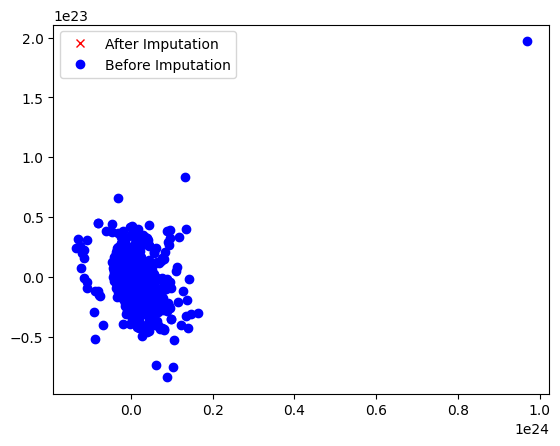

In [38]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_PCA = pca.fit_transform(X_train_final)
X_train_imputed_PCA = pca.fit_transform(X_train_imputed)
%matplotlib inline

plt.plot(X_train_PCA[:,0],X_train_PCA[:,1],'rx')
plt.plot(X_train_imputed_PCA[:,0],X_train_imputed_PCA[:,1],'bo')
plt.legend(['After anomaly removal','Before anomaly removal'])
plt.show()

In [59]:
# Submission 2
model = stacked_model.fit(X_train_final, y_train_final)

#X_test.drop('id', axis=1, inplace=True)

#X_test.to_numpy()

X_test_normalized = scaler.transform(imputer.transform(X_test))

X_test_final = X_test_normalized[:, selected_features]

y_pred = model.predict(X_test_final)

table = pd.DataFrame({'id': np.arange(len(y_pred)), 'y': y_pred.flatten()})

table.to_csv('Data\y_test_pred.csv', index=False)


C:\Users\smyan\anaconda3\envs\AML_projects\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNNImputer was fitted without feature names
  warnings.warn(


In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, Add
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Define K-Folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = []

for train_index, test_index in kf.split(X_train_final):
    X_train_cv, X_test_cv = X_train_final[train_index], X_train_final[test_index]
    y_train_cv, y_test_cv = y_train_final[train_index], y_train_final[test_index]
    
    # Build and compile the model inside the loop
    model_cv = Sequential([
        Input(shape=(X_train_cv.shape[1],)),
        Dense(512, activation='swish', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(256, activation='swish', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(128, activation='swish',kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.1),
        Dense(1)
    ])
    model_cv.compile(optimizer=AdamW(learning_rate=0.001), loss='huber')
    
    # Train the model
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
    # Include in model.fit()
    history = model_cv.fit(
        X_train_cv, y_train_cv,
        epochs=100,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )
    
    # Predict and calculate R² score
    y_pred_cv = model_cv.predict(X_test_cv).flatten()
    r2_cv = r2_score(y_test_cv, y_pred_cv)
    r2_scores.append(r2_cv)

# Calculate average R² score
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)
print(f'Cross-Validated R² Score: {mean_r2:.4f} ± {std_r2:.4f}')

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 70.2358 - val_loss: 68.7363 - learning_rate: 0.0010
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 70.1167 - val_loss: 68.7204 - learning_rate: 0.0010
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 69.3878 - val_loss: 68.5597 - learning_rate: 0.0010
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 68.4493 - val_loss: 68.1693 - learning_rate: 0.0010
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 67.2045 - val_loss: 67.5822 - learning_rate: 0.0010
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 66.0804 - val_loss: 66.8710 - learning_rate: 0.0010
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 63.8779 - val_loss: 65.9235 - learning_rate: 0.0010
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 61.2078 - val_loss: 63.8399 - learning_rate: 0.0010
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 58.4054 - val_loss: 60.7028 - learning_rate: 0.0010
E

In [80]:
model = Sequential([
    Input(shape=(X_train_final.shape[1],)),
    Dense(512, activation='swish', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='swish', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='swish', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.1),
    Dense(1)
])

model.compile(optimizer=AdamW(learning_rate=0.001), loss='huber')

# Define callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

# Train the model on the full training data with a validation split for monitoring
history = model.fit(
    X_train_final, y_train_final,
    epochs=100,
    batch_size=32,
    validation_split=0.1,  # Keep a small validation set for early stopping
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

#X_test.drop('id', axis=1, inplace=True)

#X_test.to_numpy()

X_test_normalized = scaler.transform(imputer.transform(X_test))

X_test_final = X_test_normalized[:, selected_features]

# Evaluate the model on the test data after training
y_pred = model.predict(X_test_final)

table = pd.DataFrame({'id': np.arange(len(y_pred)), 'y': y_pred.flatten()})

table.to_csv('Data\y_test_pred_nn.csv', index=False)


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 70.2795 - val_loss: 68.5752 - learning_rate: 0.0010
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 69.9272 - val_loss: 68.2338 - learning_rate: 0.0010
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 68.9895 - val_loss: 67.6251 - learning_rate: 0.0010
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 67.9433 - val_loss: 66.5970 - learning_rate: 0.0010
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 66.0875 - val_loss: 65.1146 - learning_rate: 0.0010
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 62.8665 - val_loss: 62.8079 - learning_rate: 0.0010
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 60.0249 - val_loss: 59.6871 - learning_rate: 0.0010
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 55.9410 - val_loss: 55.4070 - learning_rate: 0.0010
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 50.5705 - val_loss: 48.9655 - learning_rate: 0.0010
E

C:\Users\smyan\anaconda3\envs\AML_projects\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNNImputer was fitted without feature names
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
